### HW recap and setup

In this homework, let's repeat HW 6/7 (MNIST classification using Random Forest and Gradient Boosting).

So far we have manually found the best hyperparameters by doing something like

- for hparam1 in set1:
   - for hparam 2 in set2:
      - ...
      - compute validation score for [hparam1, hparam2, ...]

and choosing the best [hparam1,hparam2, ...] with the highest score.
However, scikit-learn already has the sklearn.model_selection.GridSearchCV class.
(See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html Links to an external site.for examples and usages.)

Your job is to simply repeat HW 6/7 but with GridSearchCV without using the for loops. If done correctly, your results should be identical to your previous results.

#### recap HW 6-7
We will train Random Forest classifier and Gradient Boosting classifier for MNIST.

Use the seed 0 everywhere.

1. Import MNIST data as we did in Lecture 7. We are only going to use digit 0 and digit 1. So extract only those examples and discard the rest.

Next, randomly split the data into 80% training data and 20% testing data. Then split the training data again into 75% training data and 25% validation data. Keep this split fixed throughout the experiments.

2. Use the validation set to choose the optimal hyperparameters "n_estimators" and "max_depth" for Random Forest, and report the best hyperparameters and the best validation error. The suggested hyperparameter values are

    - ns_estimators = [10,20,50,100,200]
    - max_depths = [1,2,5,10,20]

3. Train Random Forest again with all data (i.e., training + validation data). Report the training and the test error.

4. Plot the feature importance as an image, as we did in Lecture 7.

5. Repeat 2 with Gradient Boosting.

6. Repeat 3 with Gradient Boosting

7. Repeat 4 with Gradient Boosting.

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

Reading the data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
Y = mnist["target"] 

### 1. Import MNIST data. We are only going to use digit 0 and digit 1. Next, randomly split the data into 80% training and 20% testing... and split the training into 75% train and 25% validation data...


Again, I'm stealing the code from class to plot the digits data base

In [3]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1 

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Now let's make sure we know how to extract the 0's and 1's correctly

[0 1 1 1 1 0 1 1 0 0]
[1 0 0 1 0 1 0 0 1 1]
[0 1 1 0 0 0 1 1 1 1]
[0 1 1 0 0 0 0 1 1 1]
[1 0 0 1 1 1 0 1 1 1]


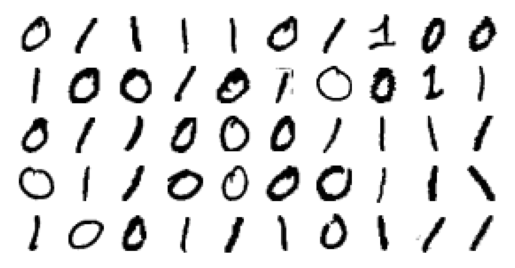

In [4]:
# mask of the 0's and 1's
mask_0_1 = ((Y==0) | (Y==1))
Y = Y[mask_0_1]
X = X[mask_0_1]
# let's check the first 50
for i in range(5):
    print(Y[i*10:i*10+10])
plot_digits(X[0:50])


That looks good. Now let's do the spliting. Same as previous HW, create a permutation and then take the first 80% and then further split into 60% (75%) and 20% (25%)

In [5]:
m = len(Y)
np.random.seed(0)

# create a random index permutation
ind =np.array(range(0,m))
ind = np.random.permutation(ind)

# see some random indices
print(ind[0:20])

[ 9612  4447  8936  4006 13853  8900  5939  6204 10640  2192 11142 13199
  7327  1875 13076 11159  7186  3673 14488   214]


In [6]:
# indices for 60% training, 20% validation , 20% test
v_split = int(m*0.8)
t_split = int(m*0.6)
train_ind = ind[0:t_split]
valid_ind = ind[t_split:v_split]
test_ind = ind[v_split:m]

### 2. Use the validation set to choose the optimal hyperparameters "n_estimators" and "max_depth" for Random Forest, and report the best hyperparameters and the best validation error.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = {"n_estimators":[10,20,50,100,200],"max_depth":[1,2,5,10,20]}
# for each combination of parameters
# I don't feel confortable using the same random seed here... but it's hw right?
forest = RandomForestClassifier(random_state=0)
forest_clf = GridSearchCV(forest, parameters)
# fit on training
forest_clf.fit(X = X[train_ind], y = Y[train_ind])
# predict on validation set
y_pred = forest_clf.predict(X[valid_ind])
# store accuracy


Now let's see who did best using the GridSeachCV attributes

In [22]:
forest_clf.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=0)

In [23]:
forest_clf.best_score_

0.9987594831911212

We can see from this that the combination that yielded the best accuracy score of  99.87% accuracy is 200 trees and a max depth of 10.

### 3. Train Random Forest again with all data (i.e., training + validation data). Report the training and the test error.

I will use the best parameters from before

In [32]:
depth_best = forest_clf.best_params_['max_depth']
n_best = forest_clf.best_params_['n_estimators']


In [33]:
full_train_ind = np.concatenate((train_ind,valid_ind)) 
# best parameters forest
forest_clf = RandomForestClassifier(n_estimators=n_best, max_depth=depth_best, random_state=0)

# fit on training and get accuracy on training set
forest_clf.fit(X = X[full_train_ind], y = Y[full_train_ind])
y_train_predict = forest_clf.predict(X[full_train_ind])
train_acc = accuracy_score(Y[full_train_ind],y_train_predict)
print("train accuracy", train_acc)
# predict and accuracy on test set
y_test_predict = forest_clf.predict(X[test_ind])
test_acc = accuracy_score(Y[test_ind],y_test_predict)
print("test accuracy", test_acc)

train accuracy 1.0
test accuracy 0.9996617050067659


From where we see that the train accuracy is 100% and the test accuracy is 99.96%.

### 4. Plot the feature importance as an image, as we did in Lecture 7.

Copying some of the code from class for the plotting and stuff

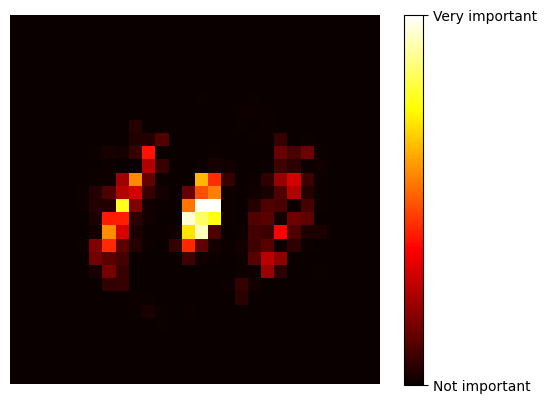

In [34]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(forest_clf.feature_importances_)

cbar = plt.colorbar(ticks=[forest_clf.feature_importances_.min(), forest_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

And we can kinda see how that makes sense as the pixels in the middle help distinguish the 1's and the pixels on the sides help distinguish the 0's.

### 5. Repeat 2 with Gradient Boosting.

Now let's rinse and repeat. 

Edit: this was taking too long to run so I time it to get an idea of how long it would take. I learned that increasing on a scale of 2 on either parameter roughly duplicate the time, and since adding powers of 2 gives the next power of 2 then the time it takes was roughly $2^{m+1}2^{n+1}$.

Since my patience doesn't go beyond 5 min I estimated a bound for the exponent 

$$
m+n+2=\log_2(5*60)\approx 8.22\quad \Longrightarrow \quad m+n=6
$$

and so I reduced my parameter space to only 3 different parameters on each space

Edit: after running it it seemed that it managed to run for a little over a minute so I can tolerate 4 times that and so I increased each parameter by 1 more.

**Edit Edit:** For the extra HW I used the same parameter grid since I didn't want to wait to much again

The for loops did a lot better in time comparison with the GridSearch ( 8 vs 22 min! I was expecting it but still urghhh so much time). Now let's see who did best

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = {"n_estimators":[10,20,50,100],"max_depth":[1,2,5,10]}
# for each combination of parameters
# I don't feel confortable using the same random seed here... but it's hw right?
gradient = GradientBoostingClassifier(random_state=0)
gradient_clf = GridSearchCV(gradient, parameters)
# fit on training
gradient_clf.fit(X = X[train_ind], y = Y[train_ind])
# predict on validation set
y_pred = gradient_clf.predict(X[valid_ind])
# store accuracy


Now let's see who did best using the GridSeachCV attributes

In [45]:
gradient_clf.best_params_

{'max_depth': 2, 'n_estimators': 100}

In [41]:
gradient_clf.best_score_

0.9974064175713492

We can see from this that the combination that yielded the best accuracy score of  99.74% accuracy is 100 trees and a max depth of 2.

### 6. Repeat 3 with Gradient Boosting

and once more...

In [46]:
depth_best = gradient_clf.best_params_['max_depth']
n_best = gradient_clf.best_params_['n_estimators']

In [47]:
full_train_ind = np.concatenate((train_ind,valid_ind)) 
# best parameters forest
gradient_clf = GradientBoostingClassifier(n_estimators=n_best, max_depth=depth_best, random_state=0)

# fit on training and get accuracy on training set
gradient_clf.fit(X = X[full_train_ind], y = Y[full_train_ind])
y_train_predict = gradient_clf.predict(X[full_train_ind])
train_acc = accuracy_score(Y[full_train_ind],y_train_predict)
print("train accuracy", train_acc)
# predict and accuracy on test set
y_test_predict = gradient_clf.predict(X[test_ind])
test_acc = accuracy_score(Y[test_ind],y_test_predict)
print("test accuracy", test_acc)

train accuracy 0.9999154262516915
test accuracy 0.9983085250338295


From where we see that the train accuracy is 99.99% and the test accuracy is 99.83%.

### 7. Repeat 4 with Gradient Boosting

and more...

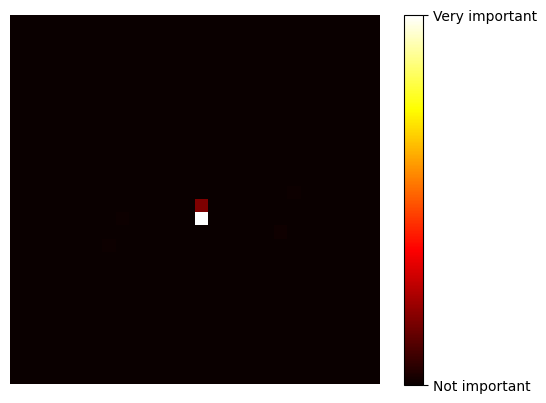

In [48]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(gradient_clf.feature_importances_)

cbar = plt.colorbar(ticks=[gradient_clf.feature_importances_.min(), gradient_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

And we get very different results! it seems like it can make an extremely good distintion using only two pixels. (This doesn't seem to be a very robust classifier in my opinion, but it was a cool outcome nevertheless)